In [154]:
import re
import pandas as pd
import numpy as np
import joblib
import glob
from sklearn.cluster import KMeans


class VRPSolver:
    def __init__(self, instance, n_clusters=10, n_jobs=1):
        self.name, self.vehicle_number, self.vehicle_capacity, columns_names, lines = self.read_data(instance)
        self.df = pd.DataFrame(data=lines, columns=columns_names, dtype=int).set_index('cust_no')
        self.distances = None
        self.n_jobs = n_jobs
        with joblib.Parallel(n_jobs=self.n_jobs) as parallel:
            self.distances = parallel(joblib.delayed(self._dist_from_to)(i, j)
                                      for i in range(self.df.shape[0]) for j in range(i))
        assert self.distances is not None, 'Lul wat'
        self.distances = dict(self.distances)
        self.current_route = list()
        self.arrival = np.zeros(self.df.shape[0])
        self.possible_arrival = np.zeros(self.df.shape[0])
        self.solution = list()
        self.start_serving = np.zeros(self.df.shape[0])
        self.opened = self.df.loc[:, 'ready_time']
        self.closed = self.df.loc[:, 'due_date']
        self.service = self.df.loc[:, 'service_time']
        self.demand = self.df.loc[:, 'demand']
        self.current_cluster = None

        kmc = KMeans(n_clusters, n_jobs=self.n_jobs)
        coords = self.df.loc[:, ['xcoord', 'ycoord']]
        self.df['cluster'] = kmc.fit_predict(coords)

    def read_data(self, filepath):
        with open(filepath, 'r') as f:
            name = f.readline()
            f.readline()
            f.readline()
            f.readline()
            vehicle_number, vehicle_capacity = re.sub('\s\s+', ';', f.readline().strip()).split(';')
            f.readline()
            f.readline()
            columns_names = re.sub('\s\s+', ';', f.readline().strip()).lower().split(';')
            columns_names = [re.sub(' ', '_', name.strip('.')) for name in columns_names]
            f.readline()
            lines = f.readlines()
            lines = [re.sub('\s\s+', ';', line.strip()).split(';') for line in lines]
            return name, int(vehicle_number), int(vehicle_capacity), columns_names, lines

    def _dist_from_to(self, client_i, client_j):
        return ((client_i, client_j), np.linalg.norm(
            self.df.loc[client_i, ['xcoord', 'ycoord']].values
            - self.df.loc[client_j, ['xcoord', 'ycoord']].values
        ))

    def dist(self, client_i, client_j):
        if client_i == client_j:
            return 0.0
        if client_i < client_j:
            return self.distances[(client_j, client_i)]
        else:
            return self.distances[(client_i, client_j)]

    def _unload_and_move(self, i, j):
        return self.arrival[i] + self.service[i] + self.dist(i, j)

    def _c1(self, u, i, j):
        return self.dist(i, u) + self.dist(u, j) - self.dist(i, j)

    def _c2(self, u, i, j):
        return self.closed[j] - (self._unload_and_move(i, j)) \
               - (self.closed[j] - (self._possible_arrival(u, i) + self.service[u] + self.dist(u, j)))

    def _c3(self, u, i, j):
        return self.closed[u] - (self._unload_and_move(i, u))

    def _local_disturbance(self, u, i, j):
        b1 = b2 = b3 = 1 / 3
        c1 = self._c1(u, i, j)
        c2 = self._c2(u, i, j)
        c3 = self._c3(u, i, j)
        return b1 * c1 + b2 * c2 + b3 * c3

    def _possible_arrival(self, u, i):
        """Time of arrival after possible insertion `u` after `i`"""
        return np.max([self._unload_and_move(i, u), self.opened[u]])

    def _is_feasible_insertion(self, u, i, j):
        arrival_u = self._possible_arrival(u, i)
        is_feasible = arrival_u + self.service[u] + self.dist(u, j) < self.closed[j]
        return is_feasible

    def _global_disturbance(self, u, feasible_insertion_points):
        local_disturbances = [(i, self._local_disturbance(u, i, j)) for i, j in feasible_insertion_points]
        insertion_point = local_disturbances[np.argmin(local_disturbances, axis=0)[1]][0]
        mean_disturbance = np.sum(local_disturbances, axis=0)[1] / len(local_disturbances)
        return mean_disturbance, insertion_point

    def _accessibility(self, u, feasible_insertion_points):
        return 1 / self._global_disturbance(u, feasible_insertion_points)

    def _internal_impact(self, u, feasible_insertion_points):
        return self._global_disturbance(u, feasible_insertion_points)

    def _own_impact(self, u, feasible_insertion_points):
        #return self.arrival[u] - self.opened[u]
        return 0.0

    def _external_impact(self, u, feasible_insertion_points):
        non_routed_points = self.current_cluster.query('index != @u')
        return (1 / non_routed_points.shape[0]) * non_routed_points.apply(
            lambda x: np.max([
                x.due_date - self.current_cluster.loc[u, 'ready_time'] - self.dist(u, x.index),
                self.current_cluster.loc[u, 'due_date'] - x.ready_time - self.dist(u, x.index),
            ]), axis=1).sum()

    def _impact(self, u, possible_insertions):
        bo = 0.0
        bi = be = 1 / 2
        feasible_insertion_points = [(i, j) for i, j in possible_insertions
                                     if self._is_feasible_insertion(u, i, j)]
        internal_impact, insertion_point = self._internal_impact(u, feasible_insertion_points)
        weighted_internal_impact = bi * internal_impact
        weighted_own_impact = bo * self._own_impact(u, feasible_insertion_points)
        weighted_external_impact = be * self._external_impact(u, feasible_insertion_points)
        return weighted_internal_impact + weighted_own_impact + weighted_external_impact, insertion_point

    def _cost_function(self, route):
        return np.sum(self.dist(client, route[i + 1]) for i, client in enumerate(route[:-1]))

    def _check_route(self):
        assert self.current_route[0] == 0, 'Route doesn\'t start at depot'
        assert self.current_route[-1] == 0, 'Route doesn\'t end in depot'
        is_not_overloaded = np.sum((self.demand[i] for i in self.current_route)) <= self.vehicle_capacity
        return is_not_overloaded

    def _pick_seed_customer(self, candidates):
        return np.random.choice(candidates.index)

    def get_initial_solution(self):
        def tupled(y, func, kwargs):
            return tuple([y, func(*kwargs)])

        for cluster_i in self.df.cluster.unique()[:1]:
            self.current_route.append(0)
            self.current_cluster = self.df.query('cluster == @cluster_i and index != "0"')
            seed = self._pick_seed_customer(self.current_cluster)
            self.current_route.append(seed)
            self.arrival[seed] = np.max([self.dist(0, seed), self.opened[seed]])
            self.current_route.append(0)
            self.current_cluster.query('index != @seed', inplace=True)
            while self.current_cluster.shape[0] != 0 and self._check_route():
                with joblib.Parallel(n_jobs=8) as parallel:
                    insertion_points = parallel(
                        joblib.delayed(tuple)([customer, self.current_route[i + 1]]) for i, customer in
                        enumerate(self.current_route[:-1])
                    )
                    #insertion_candidates_impact = parallel(
                    #    joblib.delayed(tupled)(candidate, self._impact, (candidate, insertion_points))
                    #    for candidate in self.current_cluster
                    #)
                    insertion_candidates_impact = [(candidate, self._impact(candidate, insertion_points))
                                                   for candidate in self.current_cluster.index]
                chosen_one = min(insertion_candidates_impact, key=lambda x: x[1][0])
                insertion_point = chosen_one
                self.current_route.append(chosen_one)
                self.current_cluster.query('index != @chosen_one', inplace=True)
            self.solution.append(self.current_route)
            self.current_cluster = None
            self.current_route = list()
        return len(self.solution), self.solution

In [152]:
slv = VRPSolver(instances[0], 10)

In [164]:
non_routed_points = slv.current_cluster.query('index != "23"')
print((1 / non_routed_points.shape[0]) * non_routed_points.apply(
    lambda x: np.max([
        x.due_date - slv.df.loc[23, 'ready_time'],
        slv.df.loc[23, 'due_date'] - x.ready_time,
    ]), axis=1))

cust_no
20    83.5
21    37.9
22    32.7
24    83.0
25    75.7
26    34.3
27    66.6
28    36.9
29    55.7
30    47.7
dtype: float64


In [172]:
print(non_routed_points.apply(lambda x: x.name, axis=1))

cust_no
20    20
21    21
22    22
24    24
25    25
26    26
27    27
28    28
29    29
30    30
dtype: int64


In [184]:
for i, c in enumerate(a):
    if c == 38:
        a.insert(i+1, 900)
        break
a

[1, 6, 2, 900, 900, 89, 900, 900, 900, 4, 67, 0, 7, 34, 5, 7, 23, 38, 900]

In [175]:
a = [1,6,2,89,4,67,0,7,34,5,7,23,38]
a.insert(a.(89), 900)
a

AttributeError: 'list' object has no attribute 'find'

In [115]:
import joblib

def tupled(a, func, kwargs):
    return tuple([a, func(*kwargs)])

def plus10plusb(a, b):
    return a + 10 + b

from joblib import Parallel, delayed
with Parallel(n_jobs=8) as parallel:
    arr = np.arange(200)
    a = parallel(joblib.delayed(tupled)(candidate, self._impact, (candidate, insertion_points))
                 for candidate in self.current_cluster)

In [116]:
a

[(0, 109),
 (1, 110),
 (2, 111),
 (3, 112),
 (4, 113),
 (5, 114),
 (6, 115),
 (7, 116),
 (8, 117),
 (9, 118),
 (10, 119),
 (11, 120),
 (12, 121),
 (13, 122),
 (14, 123),
 (15, 124),
 (16, 125),
 (17, 126),
 (18, 127),
 (19, 128),
 (20, 129),
 (21, 130),
 (22, 131),
 (23, 132),
 (24, 133),
 (25, 134),
 (26, 135),
 (27, 136),
 (28, 137),
 (29, 138),
 (30, 139),
 (31, 140),
 (32, 141),
 (33, 142),
 (34, 143),
 (35, 144),
 (36, 145),
 (37, 146),
 (38, 147),
 (39, 148),
 (40, 149),
 (41, 150),
 (42, 151),
 (43, 152),
 (44, 153),
 (45, 154),
 (46, 155),
 (47, 156),
 (48, 157),
 (49, 158),
 (50, 159),
 (51, 160),
 (52, 161),
 (53, 162),
 (54, 163),
 (55, 164),
 (56, 165),
 (57, 166),
 (58, 167),
 (59, 168),
 (60, 169),
 (61, 170),
 (62, 171),
 (63, 172),
 (64, 173),
 (65, 174),
 (66, 175),
 (67, 176),
 (68, 177),
 (69, 178),
 (70, 179),
 (71, 180),
 (72, 181),
 (73, 182),
 (74, 183),
 (75, 184),
 (76, 185),
 (77, 186),
 (78, 187),
 (79, 188),
 (80, 189),
 (81, 190),
 (82, 191),
 (83, 192),
 (

In [6]:
import glob
import scipy

instances = glob.glob('./instances/*.txt')

In [7]:
from sklearn.cluster import KMeans

In [15]:
kmc = KMeans(10, n_jobs=-1)
coords = slv.df.loc[:, ['xcoord', 'ycoord']]
kmc.fit(coords)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
clusters = kmc.predict(coords)

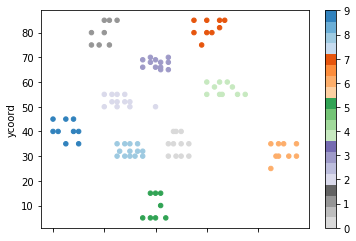

In [25]:
slv.df.plot.scatter(0, 1, c=clusters, colormap='tab20c_r')

In [11]:
slv.df.sort_values('ready_time').head(10)

,xcoord,ycoord,demand,ready_time,due_date,service_time
cust_no,,,,,,
0,40,50,0,0,1236,0
20,30,50,10,10,265,90
67,47,40,10,12,275,90
65,48,40,10,12,223,90
5,42,65,10,15,226,90
24,25,50,10,15,333,90
3,42,66,10,16,336,90
43,33,35,10,16,273,90
42,33,32,20,19,345,90


In [28]:
slv.df['cluster'] = clusters
slv.df.groupby('cluster').demand.sum()

cluster
0    200
1    190
2    170
3    180
4    170
5    200
6    150
7    190
8    160
9    200
Name: demand, dtype: int32

In [27]:
slv.vehicle_capacity

'200'

In [161]:
def check_solution(s):
    pass

In [ ]:
def iterated_local_search():
    pass
def guided_local_search():
    pass